## Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/2024_top3_eda.csv")

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

df

,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_time,end_time,duration
0,classic_bike,2024-03-05 16:22:21.209,2024-03-05 16:27:31.958,W 21 St & 6 Ave,8 Ave & W 27 St,16.372500,16.458611,5.179150
1,classic_bike,2024-03-09 15:20:28.187,2024-03-09 15:35:11.183,W 21 St & 6 Ave,8 Ave & W 27 St,15.341111,15.586389,14.716600
2,electric_bike,2024-03-14 13:18:08.205,2024-03-14 13:24:04.862,W 21 St & 6 Ave,8 Ave & W 27 St,13.302222,13.401111,5.944283
3,electric_bike,2024-03-05 12:28:59.121,2024-03-05 12:33:58.145,W 21 St & 6 Ave,8 Ave & W 27 St,12.483056,12.566111,4.983733
4,electric_bike,2024-03-14 06:29:53.388,2024-03-14 06:32:09.311,W 21 St & 6 Ave,E 17 St & Broadway,6.498056,6.535833,2.265383
...,...,...,...,...,...,...,...,...
871379,classic_bike,2024-03-13 14:53:51.084,2024-03-13 15:00:58.722,W 21 St & 6 Ave,8 Ave & W 27 St,14.897500,15.016111,7.127300
871380,classic_bike,2024-03-10 14:46:09.276,2024-03-10 14:47:51.774,8 Ave & W 31 St,8 Ave & W 27 St,14.769167,14.797500,1.708300
871381,electric_bike,2024-03-01 14:57:35.469,2024-03-01 15:07:35.691,8 Ave & W 31 St,E 17 St & Broadway,14.959722,15.126389,10.003700
871382,electric_bike,2024-03-06 08:16:14.629,2024-03-06 08:36:22.402,8 Ave & W 31 St,E 72 St & York Ave,8.270556,8.606111,20.129550


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871384 entries, 0 to 871383
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   rideable_type       871384 non-null  object        
 1   started_at          871384 non-null  datetime64[ns]
 2   ended_at            871384 non-null  datetime64[ns]
 3   start_station_name  871384 non-null  object        
 4   end_station_name    871384 non-null  object        
 5   start_time          871384 non-null  float64       
 6   end_time            871384 non-null  float64       
 7   duration            871384 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 53.2+ MB


In [3]:
top3_stations = df.groupby('start_station_name').size().reset_index(name='count').sort_values(by='count', ascending=False)['start_station_name'].head(3).tolist()

In [4]:
# Outflow (-1) / Inflow (+1)
outflow = df[df['start_station_name'].isin(top3_stations)].copy()
outflow = outflow[['started_at', 'start_station_name', 'rideable_type']]
outflow.columns = ['time', 'station', 'rideable_type']
outflow['flow'] = -1

inflow = df[df['end_station_name'].isin(top3_stations)].copy()
inflow = inflow[['ended_at', 'end_station_name', 'rideable_type']]
inflow.columns = ['time', 'station', 'rideable_type']
inflow['flow'] = 1

combined = pd.concat([outflow, inflow])

# Resampling (15 mins)
net_flow_df = combined.groupby([
    pd.Grouper(key='time', freq='15min'),
    'station',
    'rideable_type'
])['flow'].sum().unstack(['station', 'rideable_type'], fill_value=0)

# Reindexing to fill every 15 min
start_date = net_flow_df.index.min().floor('D')
end_date = net_flow_df.index.max().ceil('D')

full_time_idx = pd.date_range(start=start_date, end=end_date, freq='15min', inclusive='left') 
net_flow_df = net_flow_df.reindex(full_time_idx, fill_value=0)


# Initial stock: Restore at every 00:00
initial_stock = 10
daily_cumsum = net_flow_df.groupby(pd.Grouper(freq='D')).cumsum()

stock_df = initial_stock + daily_cumsum

stock_df.head()

station             University Pl & E 14 St W 21 St & 6 Ave 8 Ave & W 31 St  \
rideable_type                 electric_bike    classic_bike    classic_bike   
2023-12-31 00:00:00                      10              10              10   
2023-12-31 00:15:00                      10              10              10   
2023-12-31 00:30:00                      10              10              10   
2023-12-31 00:45:00                      10              10              10   
2023-12-31 01:00:00                      10              10              10   

station                           W 21 St & 6 Ave University Pl & E 14 St  
rideable_type       electric_bike   electric_bike            classic_bike  
2023-12-31 00:00:00            10              10                      10  
2023-12-31 00:15:00            10              10                      10  
2023-12-31 00:30:00            10              10                      10  
2023-12-31 00:45:00            10              10                      10  
2023-12-31 01:00:00            10              10                      10

In [5]:
stock_df.shape, 365*24*4

((35232, 6), 35040)

In [6]:
stock_df['8 Ave & W 31 St']['classic_bike'][96:]

2024-01-01 00:00:00    10
2024-01-01 00:15:00    11
2024-01-01 00:30:00    11
2024-01-01 00:45:00    10
2024-01-01 01:00:00    10
                       ..
2024-12-31 22:45:00    18
2024-12-31 23:00:00    18
2024-12-31 23:15:00    17
2024-12-31 23:30:00    17
2024-12-31 23:45:00    17
Freq: 15min, Name: classic_bike, Length: 35136, dtype: int64

In [7]:
# How many days in 2024?
35136/24/4

366.0

In [8]:
stock_df = stock_df.iloc[96:]
stock_df

station             University Pl & E 14 St W 21 St & 6 Ave 8 Ave & W 31 St  \
rideable_type                 electric_bike    classic_bike    classic_bike   
2024-01-01 00:00:00                      10              10              10   
2024-01-01 00:15:00                       9              10              11   
2024-01-01 00:30:00                      10               9              11   
2024-01-01 00:45:00                      10               9              10   
2024-01-01 01:00:00                       9               9              10   
...                                     ...             ...             ...   
2024-12-31 22:45:00                      12               9              18   
2024-12-31 23:00:00                      14               9              18   
2024-12-31 23:15:00                      14               9              17   
2024-12-31 23:30:00                      13               9              17   
2024-12-31 23:45:00                      14               9              17   

station                           W 21 St & 6 Ave University Pl & E 14 St  
rideable_type       electric_bike   electric_bike            classic_bike  
2024-01-01 00:00:00            10              10                      10  
2024-01-01 00:15:00             9              12                      10  
2024-01-01 00:30:00             8              12                      10  
2024-01-01 00:45:00             7              14                      10  
2024-01-01 01:00:00             7              15                      10  
...                           ...             ...                     ...  
2024-12-31 22:45:00            20              21                      19  
2024-12-31 23:00:00            19              21                      19  
2024-12-31 23:15:00            19              20                      18  
2024-12-31 23:30:00            19              22                      18  
2024-12-31 23:45:00            20              23                      18  

[35136 rows x 6 columns]

In [9]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35136 entries, 2024-01-01 00:00:00 to 2024-12-31 23:45:00
Freq: 15min
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   (University Pl & E 14 St, electric_bike)  35136 non-null  int64
 1   (W 21 St & 6 Ave, classic_bike)           35136 non-null  int64
 2   (8 Ave & W 31 St, classic_bike)           35136 non-null  int64
 3   (8 Ave & W 31 St, electric_bike)          35136 non-null  int64
 4   (W 21 St & 6 Ave, electric_bike)          35136 non-null  int64
 5   (University Pl & E 14 St, classic_bike)   35136 non-null  int64
dtypes: int64(6)
memory usage: 1.9 MB


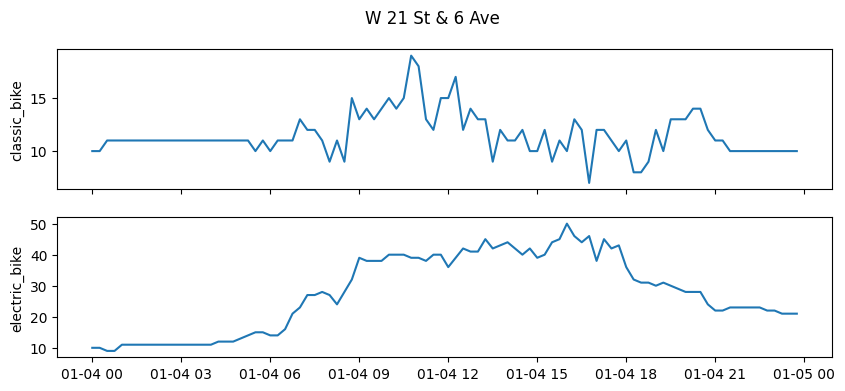

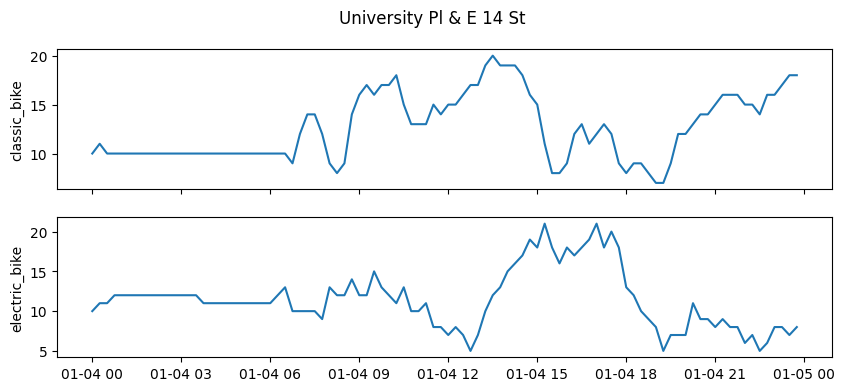

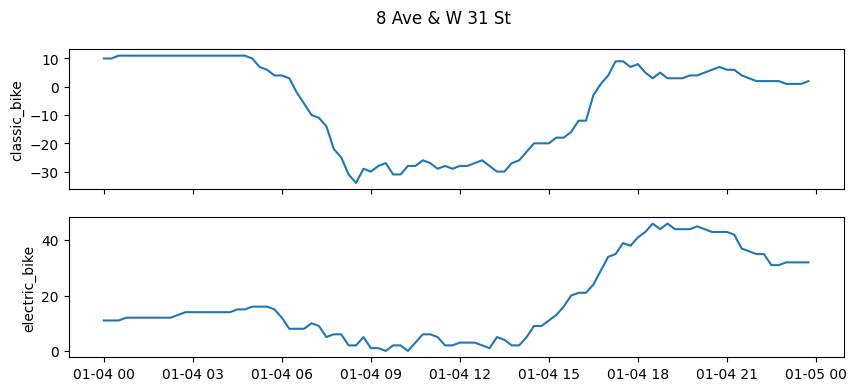

In [11]:
def figure_daily(date, station):

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
    
    fig.suptitle(f"{station}")

    sns.lineplot(stock_df.loc[date,(station,'classic_bike')], ax=ax[0])
    ax[0].set_ylabel("classic_bike")
    ax[0].set_xticklabels([])
    ax[0].set_xlabel("")
    # ax[0].xticks(rotation=45, ha='right')


    sns.lineplot(stock_df.loc[date,(station,'electric_bike')], ax=ax[1])
    ax[1].set_ylabel("electric_bike")
    # ax[1].set_xticklabels(rotation=45, ha='right')

    plt.show()

for station in top3_stations:
    figure_daily('2024-01-04', station)


In [34]:
stock_df.to_csv("../data/2024_top3_timeseries.csv", index=True)

Let us change the multi-index dataframe to long dataframe for efficient feature engineering

In [12]:
long_df = stock_df.stack(level=[0, 1], future_stack=True).reset_index()
long_df.columns = ['time', 'station', 'rideable_type', 'stock']

long_df

,time,station,rideable_type,stock
0,2024-01-01 00:00:00,University Pl & E 14 St,electric_bike,10
1,2024-01-01 00:00:00,W 21 St & 6 Ave,classic_bike,10
2,2024-01-01 00:00:00,8 Ave & W 31 St,classic_bike,10
3,2024-01-01 00:00:00,8 Ave & W 31 St,electric_bike,10
4,2024-01-01 00:00:00,W 21 St & 6 Ave,electric_bike,10
...,...,...,...,...
210811,2024-12-31 23:45:00,W 21 St & 6 Ave,classic_bike,9
210812,2024-12-31 23:45:00,8 Ave & W 31 St,classic_bike,17
210813,2024-12-31 23:45:00,8 Ave & W 31 St,electric_bike,20
210814,2024-12-31 23:45:00,W 21 St & 6 Ave,electric_bike,23


In [13]:
long_df['hour']=long_df['time'].dt.hour + long_df['time'].dt.minute/60
long_df['dayofweek']=long_df['time'].dt.dayofweek

morning_rush = (long_df['hour'] >= 8) & (long_df['hour'] <= 10)
evening_rush = (long_df['hour'] >= 17) & (long_df['hour'] <= 19)

long_df['is_rush_hour'] = (morning_rush | evening_rush).astype(int)

grouper = long_df.groupby(['station', 'rideable_type'])['stock']

long_df['lag_15m_stock'] = grouper.shift(1)
long_df['lag_30m_stock'] = grouper.shift(2)
long_df['lag_45m_stock'] = grouper.shift(3)
long_df['lag_60m_stock'] = grouper.shift(4)
long_df['target_next_stock'] = grouper.shift(-1)

start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2025-01-01')

start_ts = start_date.to_numpy().astype(np.int64)
end_ts = end_date.to_numpy().astype(np.int64)

long_df['date'] = long_df['time'].dt.normalize()


long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210816 entries, 0 to 210815
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   time               210816 non-null  datetime64[ns]
 1   station            210816 non-null  object        
 2   rideable_type      210816 non-null  object        
 3   stock              210816 non-null  int64         
 4   hour               210816 non-null  float64       
 5   dayofweek          210816 non-null  int32         
 6   is_rush_hour       210816 non-null  int64         
 7   lag_15m_stock      210810 non-null  float64       
 8   lag_30m_stock      210804 non-null  float64       
 9   lag_45m_stock      210798 non-null  float64       
 10  lag_60m_stock      210792 non-null  float64       
 11  target_next_stock  210810 non-null  float64       
 12  date               210816 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(6), int32(1), 

In [14]:
long_df['hour']=long_df['time'].dt.hour + long_df['time'].dt.minute/60
long_df['dayofweek']=long_df['time'].dt.dayofweek

morning_rush = (long_df['hour'] >= 8) & (long_df['hour'] <= 10)
evening_rush = (long_df['hour'] >= 17) & (long_df['hour'] <= 19)

long_df['is_rush_hour'] = (morning_rush | evening_rush).astype(int)

grouper = long_df.groupby(['station', 'rideable_type'])['stock']

long_df['lag_15m_stock'] = grouper.shift(1)
long_df['lag_30m_stock'] = grouper.shift(2)
long_df['lag_45m_stock'] = grouper.shift(3)
long_df['lag_60m_stock'] = grouper.shift(4)
long_df['target_next_stock'] = grouper.shift(-1)

start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2025-01-01')

start_ts = start_date.to_numpy().astype(np.int64)
end_ts = end_date.to_numpy().astype(np.int64)

long_df['date'] = long_df['time'].dt.normalize().to_numpy().astype(np.int64)

long_df['date'] = (long_df['date'] - start_ts) / (end_ts - start_ts)

final_df = long_df.dropna().copy()


final_df

,time,station,rideable_type,stock,hour,dayofweek,is_rush_hour,lag_15m_stock,lag_30m_stock,lag_45m_stock,lag_60m_stock,target_next_stock,date
24,2024-01-01 01:00:00,University Pl & E 14 St,electric_bike,9,1.0,0,0,10.0,10.0,9.0,10.0,11.0,0.000000
25,2024-01-01 01:00:00,W 21 St & 6 Ave,classic_bike,9,1.0,0,0,9.0,9.0,10.0,10.0,9.0,0.000000
26,2024-01-01 01:00:00,8 Ave & W 31 St,classic_bike,10,1.0,0,0,10.0,11.0,11.0,10.0,9.0,0.000000
27,2024-01-01 01:00:00,8 Ave & W 31 St,electric_bike,7,1.0,0,0,7.0,8.0,9.0,10.0,5.0,0.000000
28,2024-01-01 01:00:00,W 21 St & 6 Ave,electric_bike,15,1.0,0,0,14.0,12.0,12.0,10.0,15.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210805,2024-12-31 23:30:00,W 21 St & 6 Ave,classic_bike,9,23.5,1,0,9.0,9.0,9.0,9.0,9.0,0.997268
210806,2024-12-31 23:30:00,8 Ave & W 31 St,classic_bike,17,23.5,1,0,17.0,18.0,18.0,18.0,17.0,0.997268
210807,2024-12-31 23:30:00,8 Ave & W 31 St,electric_bike,19,23.5,1,0,19.0,19.0,20.0,20.0,20.0,0.997268
210808,2024-12-31 23:30:00,W 21 St & 6 Ave,electric_bike,22,23.5,1,0,20.0,21.0,21.0,21.0,23.0,0.997268


In [15]:
final_df.iloc[95*6]

time                     2024-01-02 00:45:00
station              University Pl & E 14 St
rideable_type                  electric_bike
stock                                      9
hour                                    0.75
dayofweek                                  1
is_rush_hour                               0
lag_15m_stock                            9.0
lag_30m_stock                            9.0
lag_45m_stock                            9.0
lag_60m_stock                           30.0
target_next_stock                        9.0
date                                0.002732
Name: 594, dtype: object

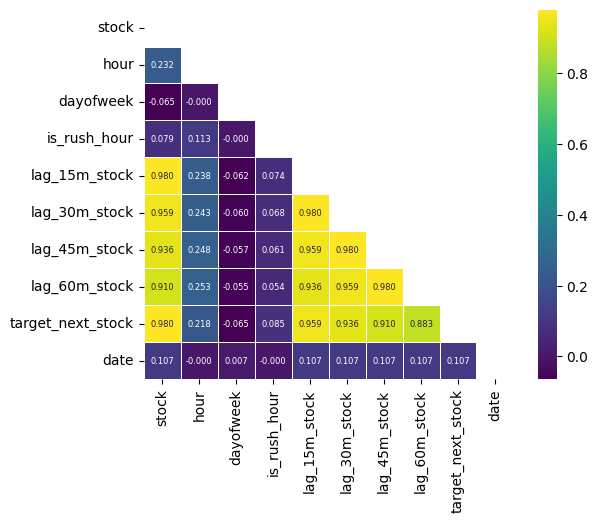

In [16]:
numerical_columns = final_df.select_dtypes(include=['number']).columns

corr = final_df[numerical_columns].corr()

mask = np.triu(np.ones_like(corr, dtype=bool) )

sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap='viridis', linewidths=0.5, square=True, annot_kws={"size": 6})
plt.show()

In [19]:
# drop `time` because it is included in other information
final_df = final_df.drop(columns=['time'])

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210786 entries, 24 to 210809
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   station            210786 non-null  object 
 1   rideable_type      210786 non-null  object 
 2   stock              210786 non-null  int64  
 3   hour               210786 non-null  float64
 4   dayofweek          210786 non-null  int32  
 5   is_rush_hour       210786 non-null  int64  
 6   lag_15m_stock      210786 non-null  float64
 7   lag_30m_stock      210786 non-null  float64
 8   lag_45m_stock      210786 non-null  float64
 9   lag_60m_stock      210786 non-null  float64
 10  target_next_stock  210786 non-null  float64
 11  date               210786 non-null  float64
dtypes: float64(7), int32(1), int64(2), object(2)
memory usage: 20.1+ MB


In [20]:
final_df.to_csv("../data/2024_top3_fe.csv", index=False)

# Modeling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_ts = pd.read_csv("../data/2024_top3_timeseries.csv", index_col=0, header=[0, 1], parse_dates=True)

df = pd.read_csv("../data/2024_top3_fe.csv")

df['station'] = df['station'].astype('category')
df['rideable_type'] = df['rideable_type'].astype('category')

top3_stations = ['W 21 St & 6 Ave', 'University Pl & E 14 St', '8 Ave & W 31 St']

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210786 entries, 0 to 210785
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   station            210786 non-null  category
 1   rideable_type      210786 non-null  category
 2   stock              210786 non-null  int64   
 3   hour               210786 non-null  float64 
 4   dayofweek          210786 non-null  int64   
 5   is_rush_hour       210786 non-null  int64   
 6   lag_15m_stock      210786 non-null  float64 
 7   lag_30m_stock      210786 non-null  float64 
 8   lag_45m_stock      210786 non-null  float64 
 9   lag_60m_stock      210786 non-null  float64 
 10  target_next_stock  210786 non-null  float64 
 11  date               210786 non-null  float64 
dtypes: category(2), float64(7), int64(3)
memory usage: 16.5 MB


In [23]:
import torch
import random
import os

# Random seed setting (Reproducibility)
def seed_everything(seed: int = 42):
    # 1. Python seed
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed) # Hash based calculation (Ex: Dictionary) 
    
    # 2. Numpy seed
    np.random.seed(seed)
    
    # 3. PyTorch CPU
    torch.manual_seed(seed)

    # 4. PyTorch GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # Multi-GPU
        
        # CuDNN deterministic option
        # It might reduce performance
        torch.backends.cudnn.deterministic = True 
        # Turn off searching optimal algorithms based on hardware
        torch.backends.cudnn.benchmark = False 

    print(f"Global Seed set to {seed}")

## VAR

In [24]:
df_ts.head()

station             University Pl & E 14 St W 21 St & 6 Ave 8 Ave & W 31 St  \
rideable_type                 electric_bike    classic_bike    classic_bike   
2024-01-01 00:00:00                      10              10              10   
2024-01-01 00:15:00                       9              10              11   
2024-01-01 00:30:00                      10               9              11   
2024-01-01 00:45:00                      10               9              10   
2024-01-01 01:00:00                       9               9              10   

station                           W 21 St & 6 Ave University Pl & E 14 St  
rideable_type       electric_bike   electric_bike            classic_bike  
2024-01-01 00:00:00            10              10                      10  
2024-01-01 00:15:00             9              12                      10  
2024-01-01 00:30:00             8              12                      10  
2024-01-01 00:45:00             7              14                      10  
2024-01-01 01:00:00             7              15                      10

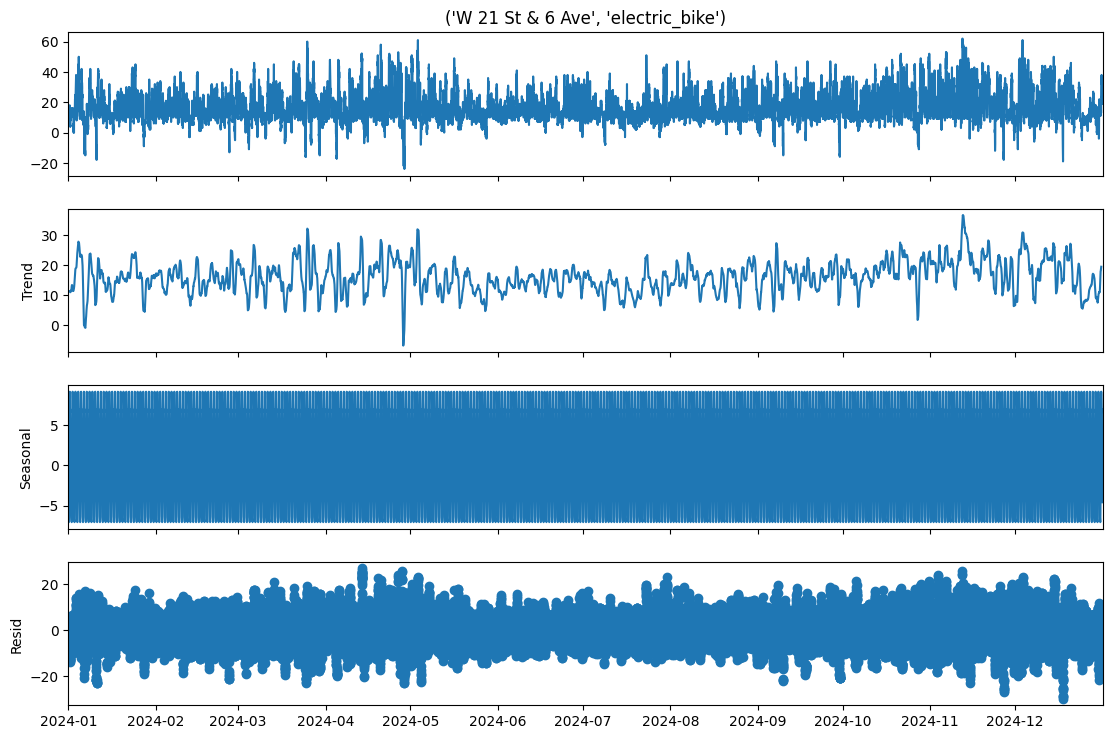

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

target_series = df_ts.loc[:, ('W 21 St & 6 Ave', 'electric_bike')]

decomposition = seasonal_decompose(target_series, model='additive', period=96)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

Train data shape: (28108, 6)
Test data shape: (7028, 6)
Optimal Lag Order: 16
Total Average RMSE: 20.1269

RMSE by Station & Type:
('University Pl & E 14 St', 'electric_bike'): 14.6997
('W 21 St & 6 Ave', 'classic_bike'): 13.3599
('8 Ave & W 31 St', 'classic_bike'): 16.9998
('8 Ave & W 31 St', 'electric_bike'): 37.9916
('W 21 St & 6 Ave', 'electric_bike'): 12.5241
('University Pl & E 14 St', 'classic_bike'): 12.1157


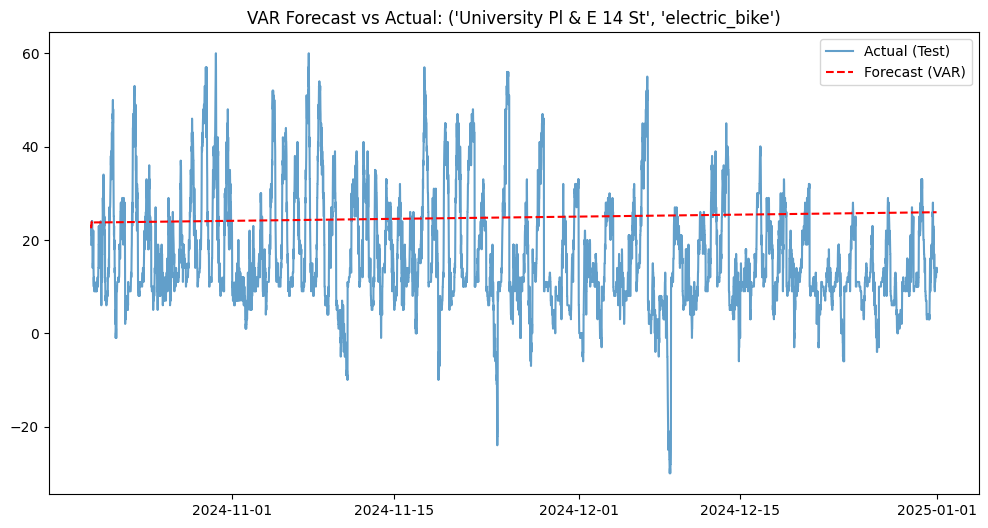

In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 1. Train / Test Split (8:2)
n_obs = len(stock_df)
split_point = int(n_obs * 0.8)

train_df = stock_df.iloc[:split_point]
test_df = stock_df.iloc[split_point:]

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Differencing
train_diff = train_df.diff().dropna()

# Train
model = VAR(train_diff)

# Find the best lag based on AIC
lags_result = model.select_order(maxlags=16)
optimal_lag = lags_result.aic 
print(f"Optimal Lag Order: {optimal_lag}")

var_result = model.fit(optimal_lag)

# Forecasting diff
# It requires the last part of the train data (Lag)
lag_order = var_result.k_ar
forecast_input = train_diff.values[-lag_order:]

fc_diff = var_result.forecast(y=forecast_input, steps=len(test_df))
fc_diff_df = pd.DataFrame(fc_diff, index=test_df.index, columns=test_df.columns)

# Inverting diff to stock
last_stock_train = train_df.iloc[-1]
forecast_stock_df = last_stock_train + fc_diff_df.cumsum()

# Overall RMSE
total_rmse = np.sqrt(mean_squared_error(test_df, forecast_stock_df))
print(f"Total Average RMSE: {total_rmse:.4f}\n")

# RMSE for each station
print("RMSE by Station & Type:")
for col in test_df.columns:
    col_rmse = np.sqrt(mean_squared_error(test_df[col], forecast_stock_df[col]))
    print(f"{col}: {col_rmse:.4f}")

# Visualization
target_col = test_df.columns[0]
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df[target_col], label='Actual (Test)', alpha=0.7)
plt.plot(forecast_stock_df.index, forecast_stock_df[target_col], label='Forecast (VAR)', color='red', linestyle='--')
plt.title(f"VAR Forecast vs Actual: {target_col}")
plt.legend()
plt.show()

## XGBoost

In [27]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform, loguniform

features = [col for col in df.columns if col!='target_next_stock']

X = df[features]
y = df['target_next_stock']

split_idx = int(len(X)*0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


model = xgb.XGBRegressor(random_state=42, enable_categorical=True, n_estimators=30, max_depth=20, learning_rate=1e-1)

model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"XGBoost RMSE: {rmse:.4f}")

XGBoost RMSE: 2.6108


In [31]:
df2025 = pd.read_csv("../data/2025_timeseries.csv", index_col=0, header=[0, 1], parse_dates=True)
df2025.head()

station             University Pl & E 14 St 8 Ave & W 31 St  \
rideable_type                  classic_bike    classic_bike   
2025-01-01 00:00:00                      10               9   
2025-01-01 00:15:00                      10               9   
2025-01-01 00:30:00                      10               8   
2025-01-01 00:45:00                      10               8   
2025-01-01 01:00:00                      10               9   

station             University Pl & E 14 St 8 Ave & W 31 St W 21 St & 6 Ave  \
rideable_type                 electric_bike   electric_bike   electric_bike   
2025-01-01 00:00:00                       8              10              10   
2025-01-01 00:15:00                       8              11              10   
2025-01-01 00:30:00                       6              13               9   
2025-01-01 00:45:00                       6              13               6   
2025-01-01 01:00:00                       6              11               6   

station                           
rideable_type       classic_bike  
2025-01-01 00:00:00           10  
2025-01-01 00:15:00           10  
2025-01-01 00:30:00           10  
2025-01-01 00:45:00           10  
2025-01-01 01:00:00            8

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192384 entries, 0 to 192383
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   time           192384 non-null  datetime64[ns]
 1   station        192384 non-null  object        
 2   rideable_type  192384 non-null  object        
 3   stock          192384 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 5.9+ MB
None
(96, 3)


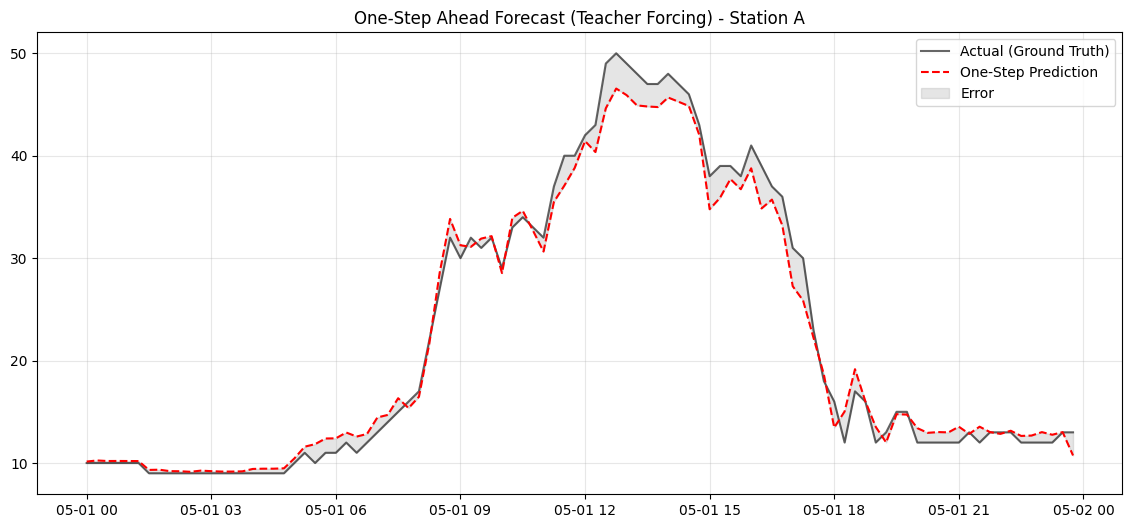

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def predict_one_step_ahead(
    model, 
    df_all,          # DataFrame containing the new information
    station_name, 
    rideable_type, 
    target_date
):
    """
    Predicts using all inputs (including lags) as 'Actual Data'.
    Processes everything at once using Pandas operations without for-loops.
    """
    
    # 1. 데이터 추출 (Station & Type & Date)
    # df_all에서 해당 station/type의 데이터를 꺼냅니다.
    # (이미 전처리가 되어 있어서 lag 컬럼이 있다고 가정하거나, 여기서 만듭니다)
    
    # 예시: MultiIndex라고 가정 (Index: start_station_name, rideable_type, started_at)
    # 혹은 User의 데이터 구조에 맞춰 필터링
    # df_target = df_all.xs((station_name, rideable_type), level=['station_name', 'rideable_type']).copy()
    
    # [수정] 사용자의 상황에 맞게 필터링한다고 가정
    # df_history는 'datetime'이 인덱스인 Series 혹은 DataFrame이어야 함
    
    # 여기서 중요한 점: Lag를 만들기 위해선 'target_date' 이전 데이터도 필요함
    # 따라서 넉넉하게 앞뒤로 데이터를 자릅니다.
    start_search = pd.to_datetime(target_date) - pd.Timedelta(hours=2) # 2시간 전부터 확보
    end_search = pd.to_datetime(target_date) + pd.Timedelta(hours=24)
    
    # 전체 데이터에서 해당 구간 필터링 (가정)
    df_all = df_all.stack(level=[0, 1], future_stack=True).reset_index()
    df_all.columns = ['time', 'station', 'rideable_type', 'stock']

    print(df_all.info())
    
    mask = (
        (df_all['station'] == station_name) & 
        (df_all['rideable_type'] == rideable_type) &
        (df_all['time'] >= start_search) & 
        (df_all['time'] <= end_search)
    )
    data = df_all.loc[mask].copy()
    
    '''
    # 만약 index가 datetime이 아니라면 설정
    if not isinstance(data.index, pd.DatetimeIndex):
        data = data.set_index('started_at').sort_index() # 컬럼명 확인 필요
    '''

    # -------------------------------------------------------
    # 2. Feature Engineering (Actual Data 기반)
    # -------------------------------------------------------
    # 여기서 만드는 모든 feature는 '실제 데이터' 기반입니다.
    
    # A. Lag Features (실제 stock 컬럼을 shift 해서 생성)
    data['lag_15m_stock'] = data['stock'].shift(1) # 1 row back (assuming 15min freq)
    data['lag_30m_stock'] = data['stock'].shift(2)
    data['lag_45m_stock'] = data['stock'].shift(3)
    data['lag_60m_stock'] = data['stock'].shift(4)
    
    # B. Time Features
    data['hour'] = data['time'].dt.hour + data['time'].dt.minute / 60.0
    data['dayofweek'] = data['time'].dt.dayofweek
    data['is_rush_hour'] = data['hour'].apply(
        lambda h: 1 if (8 <= h < 10) or (17 <= h < 19) else 0
    )
    
    # C. Date Numerical
    start_ts = pd.to_datetime('2024-01-01').value
    end_ts = pd.to_datetime('2025-01-01').value
    data['date'] = (data['time'].dt.normalize().astype(np.int64) - start_ts) / (end_ts - start_ts)

    # -------------------------------------------------------
    # 3. Target Date만 자르기
    # -------------------------------------------------------
    # Lag 생성을 위해 앞부분 데이터를 썼으니, 이제 진짜 예측할 날짜만 남깁니다.
    target_mask = (data['time'] >= pd.to_datetime(target_date + " 00:00:00")) & \
                  (data['time'] <= pd.to_datetime(target_date + " 23:45:00"))
    
    inference_df = data.loc[target_mask].copy()
    
    # -------------------------------------------------------
    # 4. Prediction
    # -------------------------------------------------------
    # 모델에 들어갈 컬럼 순서 지정 (학습 때와 똑같이!)
    features = [
        'station', 'rideable_type', 'stock', # <-- 여기 stock은 현재 시점의 stock (Input)
        'hour', 'dayofweek', 'is_rush_hour',
        'lag_15m_stock', 'lag_30m_stock', 'lag_45m_stock', 'lag_60m_stock',
        'date'
    ]
    
    # Category 타입 변환
    inference_df['station'] = inference_df['station'].astype('category')
    inference_df['rideable_type'] = inference_df['rideable_type'].astype('category')
    
    # 예측 수행 (한 번에)
    # 주의: 여기서 입력으로 들어가는 'stock'이나 'lag_stock'은 모두 실제값(Ground Truth)입니다.
    inference_df['predicted_stock'] = model.predict(inference_df[features])
    
    # -------------------------------------------------------
    # 5. 결과 정리
    # -------------------------------------------------------
    result = inference_df[['stock', 'predicted_stock']].rename(columns={'stock': 'actual_stock'})
    result['error'] = result['actual_stock'] - result['predicted_stock']
    print(result.shape)
    result['time'] = pd.date_range(start=target_date + " 00:00:00", end= target_date + " 23:45:01", freq='15min', inclusive='left')

    result = result.set_index('time')
    
    return result

# -------------------------------------------------------
# 실행 및 시각화
# -------------------------------------------------------
# 가정: df2025는 전체 데이터가 들어있는 DataFrame
# df2025.index는 datetime, 컬럼에 'station', 'rideable_type', 'stock' 등이 있어야 함

df_result = predict_one_step_ahead(
    model=model,
    df_all=df2025,  # 전체 데이터
    station_name=top3_stations[0],
    rideable_type='classic_bike',
    target_date='2025-05-01'
)

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(df_result.index, df_result['actual_stock'], label='Actual (Ground Truth)', color='black', alpha=0.6)
plt.plot(df_result.index, df_result['predicted_stock'], label='One-Step Prediction', color='red', linestyle='--')

# 에러 면적 표시
plt.fill_between(df_result.index, df_result['actual_stock'], df_result['predicted_stock'], color='gray', alpha=0.2, label='Error')

plt.title(f"One-Step Ahead Forecast (Teacher Forcing) - Station A")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.show()

Global Seed set to 42
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/hyunwoooh/citi-bike/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best parameters: {'learning_rate': np.float64(0.20894166286818883), 'max_depth': 6, 'n_estimators': 58}
XGBoost RMSE: 2.0787


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

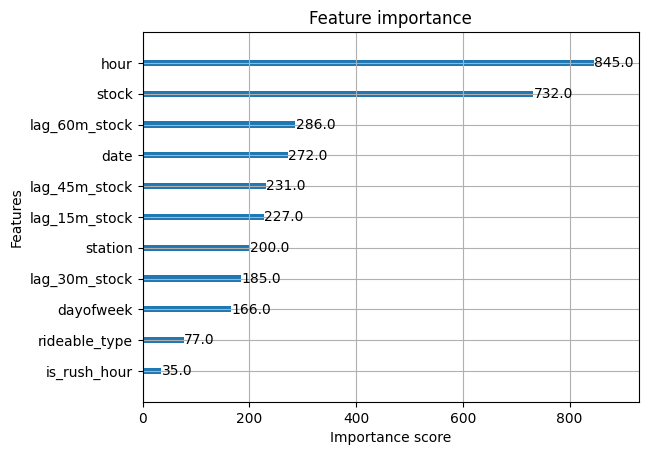

In [35]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform, loguniform

features = [col for col in df.columns if col!='target_next_stock']

X = df[features]
y = df['target_next_stock']

split_idx = int(len(X)*0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


param_dist = {
    'n_estimators': randint(5, 100),
    'max_depth': randint(3, 20),
    'learning_rate': uniform(1e-3, 1)
}

seed_everything(42)

model = xgb.XGBRegressor(random_state=42, enable_categorical=True)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=4,
    verbose=1
)

random_search.fit(X_train, y_train)

model_xgb = random_search.best_estimator_

print(f"best parameters: {random_search.best_params_}")

#model_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
#model_xgb.fit(X_train, y_train)


preds = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"XGBoost RMSE: {rmse:.4f}")

xgb.plot_importance(model_xgb)


## LSTM

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# GPU/MPS(Mac)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210786 entries, 0 to 210785
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   station            210786 non-null  category
 1   rideable_type      210786 non-null  category
 2   stock              210786 non-null  int64   
 3   hour               210786 non-null  float64 
 4   dayofweek          210786 non-null  int64   
 5   is_rush_hour       210786 non-null  int64   
 6   lag_15m_stock      210786 non-null  float64 
 7   lag_30m_stock      210786 non-null  float64 
 8   lag_45m_stock      210786 non-null  float64 
 9   lag_60m_stock      210786 non-null  float64 
 10  target_next_stock  210786 non-null  float64 
 11  date               210786 non-null  float64 
dtypes: category(2), float64(7), int64(3)
memory usage: 16.5 MB


In [38]:
from sklearn.preprocessing import MinMaxScaler

df_onehot = pd.get_dummies(df, columns=['station', 'rideable_type'])

# lag features are not needed for LSTM
features = [col for col in df_onehot if col!='target_next_stock' and col!='time']
target = 'target_next_stock'

X = df_onehot[features].to_numpy()
y = df_onehot[target].to_numpy().reshape(-1, 1)


scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y)

# How long will it lookback? (24 hours)
LOOKBACK_WINDOW = 24*4

def create_sequences(X_data, y_data, lookback):
    X_seq, y_seq = [], []
    # Need to leave a space equal to the lookback window before the end of the data
    for i in range(len(X_data) - lookback):
        # Group the data from i up to just before i+lookback into one chunk (the past 24 hours)
        X_seq.append(X_data[i:i+lookback])
        # The target value at the i+lookback time point (the future time point to predict)
        y_seq.append(y_data[i+lookback])
    return np.array(X_seq), np.array(y_seq)

# 3D tensor
X_lstm, y_lstm = create_sequences(scaled_X, scaled_y, LOOKBACK_WINDOW)

X_lstm = X_lstm.astype(np.float32)
y_lstm = y_lstm.astype(np.float32)

# Check the shape
# Result example: (Number of samples, 24 (hours), 8 (number of features))
print(f"LSTM Input Shape: {X_lstm.shape}")
print(f"LSTM Target Shape: {y_lstm.shape}")




split_idx = int(len(X_lstm) * 0.8)

X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

print(f"Train shape: {X_train_lstm.shape}, Test shape: {X_test_lstm.shape}")

seed_everything(42)

# 1. numpy to torch.tensor
# (Samples, TimeSteps, Features)
X_train_tensor = torch.from_numpy(X_train_lstm).to(device)
y_train_tensor = torch.from_numpy(y_train_lstm).to(device)
X_test_tensor = torch.from_numpy(X_test_lstm).to(device)
y_test_tensor = torch.from_numpy(y_test_lstm).to(device)

# 2. DataLoader 
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # Don't shuffle for time series

LSTM Input Shape: (210690, 96, 14)
LSTM Target Shape: (210690, 1)
Train shape: (168552, 96, 14), Test shape: (42138, 96, 14)
Global Seed set to 42


In [39]:
class BikeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(BikeLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        # batch_first=True: Sets input dimension to (Batch, Seq, Feature)
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_prob
        )
        
        # Fully Connected Layer (Output)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)
        
        # If h0, c0 are not set, they are automatically initialized to 0
        # out shape: (Batch, Seq_Len, Hidden_Size)
        out, (hn, cn) = self.lstm(x)
        
        # Use only the Hidden State of the last Time Step for a Many-to-One structure
        # out[:, -1, :] : Data from the last time step for all batches
        out = out[:, -1, :] 
        
        # Final prediction
        out = self.fc(out)
        return out
    

# Random seed
seed_everything(42)

# Hyperparameters
input_size = X_train_lstm.shape[2] # Number of features
hidden_size = 64
num_layers = 2 
output_size = 1
dropout_prob = 0.0 

model = BikeLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob).to(device)
print(model)

Global Seed set to 42
BikeLSTM(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [40]:
# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
train_losses = []

model.train() # train mode

for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    for inputs, targets in train_loader:
        # 1. Reset Gradients
        optimizer.zero_grad()
        
        # 2. Forward Pass
        outputs = model(inputs)
        
        # 3. Loss
        loss = criterion(outputs, targets)
        
        # 4. Backward Pass & Optimize
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    
    # Loss
    epoch_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

Epoch [5/100], Loss: 0.005598
Epoch [10/100], Loss: 0.005598


KeyboardInterrupt: 

In [43]:
from sklearn.metrics import mean_squared_error

model.eval() # Evaluation mode
model.to('cpu')
with torch.no_grad():
    # Predict
    predictions = model(X_test_tensor.cpu())
    
    # GPU to CPU to numpy
    predictions = predictions.cpu().numpy()
    y_test_actual = y_test_tensor.cpu().numpy()

# Inverse Transform
predicted_stock = scaler_y.inverse_transform(predictions)
actual_stock = scaler_y.inverse_transform(y_test_actual)

# RMSE
rmse_torch = np.sqrt(mean_squared_error(actual_stock, predicted_stock))
print(f"LSTM RMSE: {rmse_torch:.4f}")

LSTM RMSE: 12.9794
